<a href="https://colab.research.google.com/github/MSaiPrabhas/Autoregressive-integrated-moving-average-Air-Pollution-/blob/main/BHPP_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import data_table
import re
import sklearn.linear_model as skl_lm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn import preprocessing
from sklearn import neighbors

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline
plt.style.use('seaborn-white')


<IPython.core.display.Javascript object>

<ipython-input-3-7a7a1c9a5ecd>:28: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

<IPython.core.display.Javascript object>

Mounted at /content/drive


In [ ]:
df1 = pd.read_csv("/content/drive/MyDrive/p2.csv")
df1.tail()
dataset =df1.drop(labels =13319)

<IPython.core.display.Javascript object>

In [ ]:
dataset

<IPython.core.display.Javascript object>

,area_type,availability,location,size,society,total_sqft,bath,balcony,price,metro
0,Built-up Area,Ready To Move,Anekal,1 RK,NaN,351,1.0,1.0,16.00,0.0
1,Super built-up Area,Ready To Move,Banaswadi,1 RK,Krntsee,527,1.0,0.0,35.00,1.0
2,Super built-up Area,Ready To Move,Basavangudi,1 RK,NaN,670,1.0,1.0,50.00,1.0
3,Super built-up Area,19-Dec,Bhoganhalli,1 RK,Rosha I,296,1.0,0.0,22.89,0.0
4,Super built-up Area,Ready To Move,Devarabeesana Halli,2 BHK,NaN,1100,2.0,1.0,70.00,0.0
...,...,...,...,...,...,...,...,...,...,...
13314,Super built-up Area,Ready To Move,Yeshwanthpur,3 BHK,IBityin,1675,3.0,NaN,92.13,1.0
13315,Super built-up Area,Ready To Move,Yeshwanthpur Industrial Suburb,3 BHK,NaN,2100,3.0,2.0,240.00,1.0
13316,Super built-up Area,Ready To Move,Yeshwanthpur Industrial Suburb,2 BHK,Essic C,1415,2.0,2.0,120.00,1.0
13317,Super built-up Area,Ready To Move,Yeshwanthpur Industrial Suburb,6 BHK,Essic C,3800,6.0,NaN,390.00,1.0


In [ ]:
print(f'Number of rows and columns of the dataset are {dataset.shape } respectively')  

<IPython.core.display.Javascript object>

Number of rows and columns of the dataset are (13319, 10) respectively


<IPython.core.display.Javascript object>

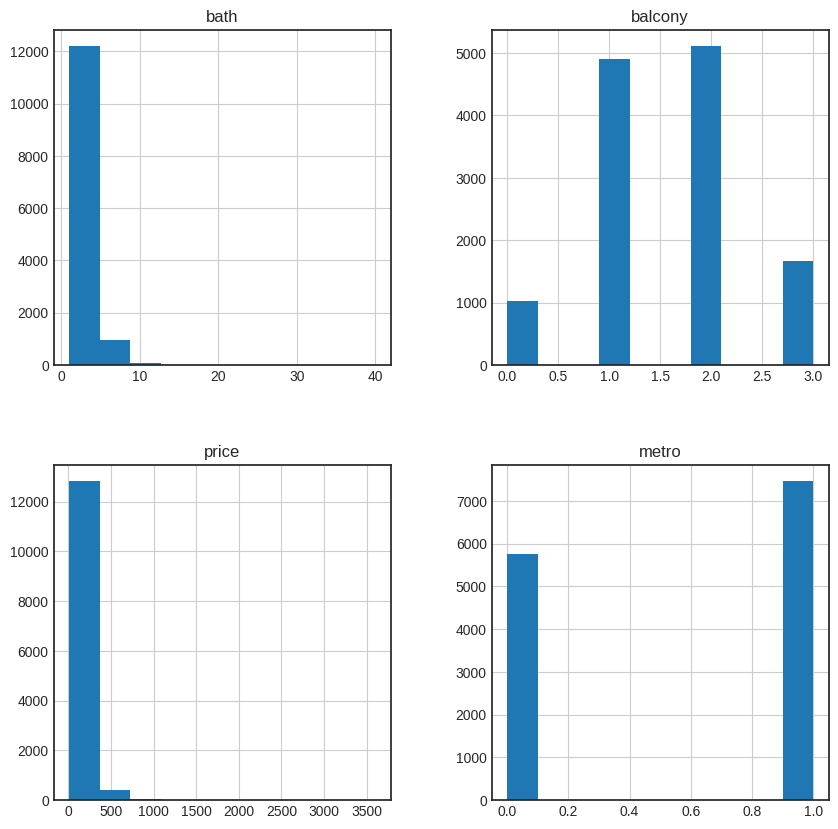

In [ ]:
# Suggested starting size of figure [10, 10] to utilize whitespace in notebook.
plt.rcParams['figure.figsize'] = [10, 10]
dataset.hist();

<IPython.core.display.Javascript object>

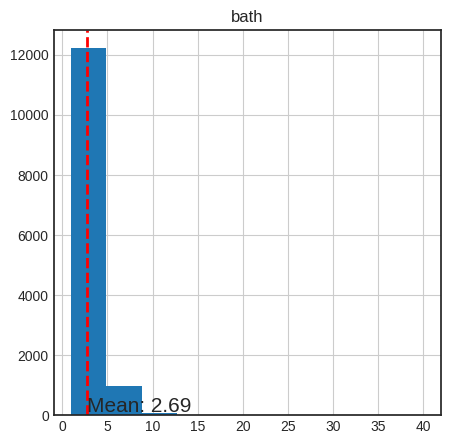

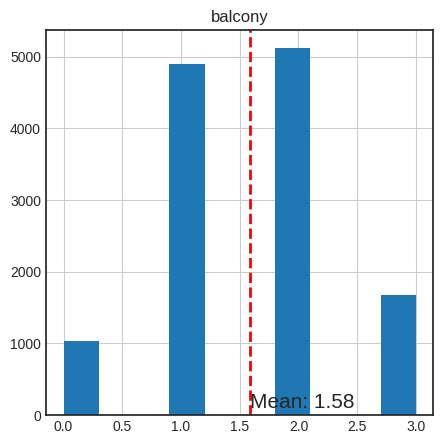

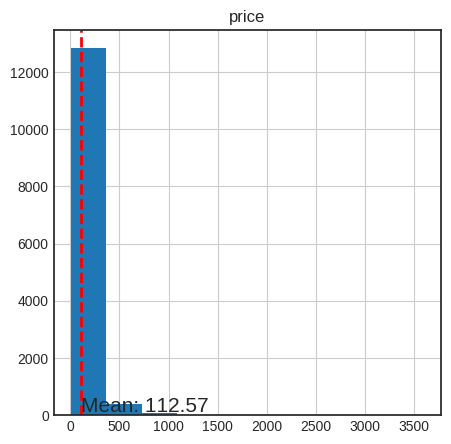

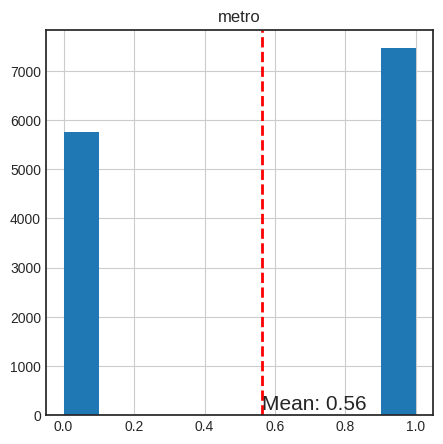

In [ ]:
col_Names = [feature for feature in dataset.columns if dataset[feature].dtype != 'O']
plt.rcParams['figure.figsize'] = [5,5]
for i in col_Names:
  dataset[i].hist()
  plt.axvline(dataset[i].mean(), color='red', linestyle='dashed', linewidth=2)
  plt.title(i)
  plt.text(dataset[i].mean(), 100, f"Mean: {dataset[i].mean():.2f}", fontsize=15)
  plt.show()

In [ ]:
#We can remove availability since generally it should not affect the selling price.
#also finally when we will build the app, there we if we keep availability, we have to select from many options as
#availability can be any day in a year, so better drop this column
dataset = dataset.drop(['availability', 'society'], axis = 'columns')
dataset.head()

<IPython.core.display.Javascript object>

,area_type,location,size,total_sqft,bath,balcony,price,metro
0,Built-up Area,Anekal,1 RK,351,1.0,1.0,16.00,0.0
1,Super built-up Area,Banaswadi,1 RK,527,1.0,0.0,35.00,1.0
2,Super built-up Area,Basavangudi,1 RK,670,1.0,1.0,50.00,1.0
3,Super built-up Area,Bhoganhalli,1 RK,296,1.0,0.0,22.89,0.0
4,Super built-up Area,Devarabeesana Halli,2 BHK,1100,2.0,1.0,70.00,0.0


In [ ]:
dataset.info()

<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13319 entries, 0 to 13318
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   area_type   13319 non-null  object 
 1   location    13319 non-null  object 
 2   size        13303 non-null  object 
 3   total_sqft  13319 non-null  object 
 4   bath        13246 non-null  float64
 5   balcony     12710 non-null  float64
 6   price       13319 non-null  float64
 7   metro       13220 non-null  float64
dtypes: float64(4), object(4)
memory usage: 832.6+ KB


In [ ]:
#1st step is to replace the null values
#Find the no. of null values for each feature 
dataset.isnull().sum()

<IPython.core.display.Javascript object>

area_type       0
location        0
size           16
total_sqft      0
bath           73
balcony       609
price           0
metro          99
dtype: int64

<IPython.core.display.Javascript object>

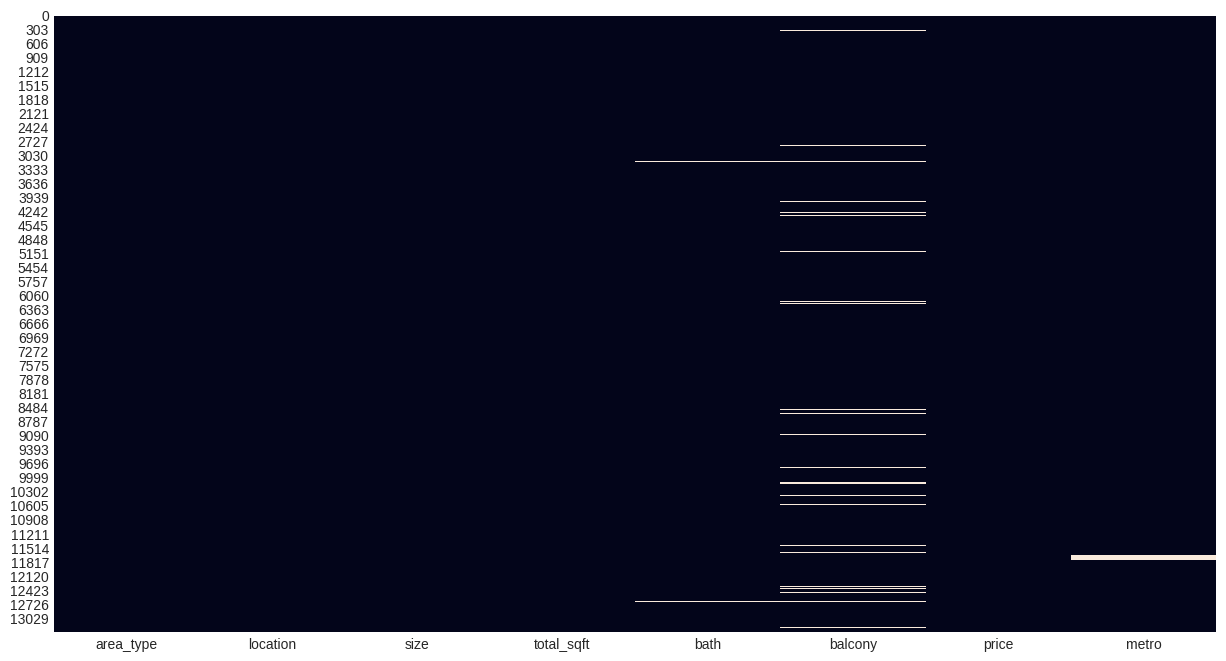

In [ ]:
# visualization for missing value
plt.figure(figsize=(15, 8))

# plot heatmap to check null values

sns.heatmap(dataset.isnull(), cbar=False)

# display the plot
plt.show()

In [ ]:
#1st find all the numerical features
numerical_features = [feature for feature in dataset.columns if dataset[feature].dtype != 'O']
numerical_features

<IPython.core.display.Javascript object>

['bath', 'balcony', 'price', 'metro']

In [ ]:
dataset[numerical_features].isnull().sum()


<IPython.core.display.Javascript object>

bath        73
balcony    609
price        0
metro       99
dtype: int64

In [ ]:
#We will drop a column only if the number of null values are more than 50% of total no. of records(i.e 13320)
#So, we aren't dropping any numerical feature
#Replace the numerical features with mean
num_features_to_fill = ['bath', 'balcony', 'price']
for feature in num_features_to_fill:
    dataset[feature] = dataset[feature].fillna(dataset[feature].mean())
    
dataset[numerical_features].isnull().sum()
# Count the number of null values in the metro column
num_nulls = dataset["metro"].isnull().sum()

# Generate a list of 0s and 1s with the same length as the number of null values
values = [0, 1]
random_list = np.random.choice(values, num_nulls)

# Shuffle the list of 0s and 1s randomly
np.random.shuffle(random_list)

# Replace null values in the metro column with the shuffled list
dataset.loc[dataset["metro"].isnull(), "metro"] = random_list

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

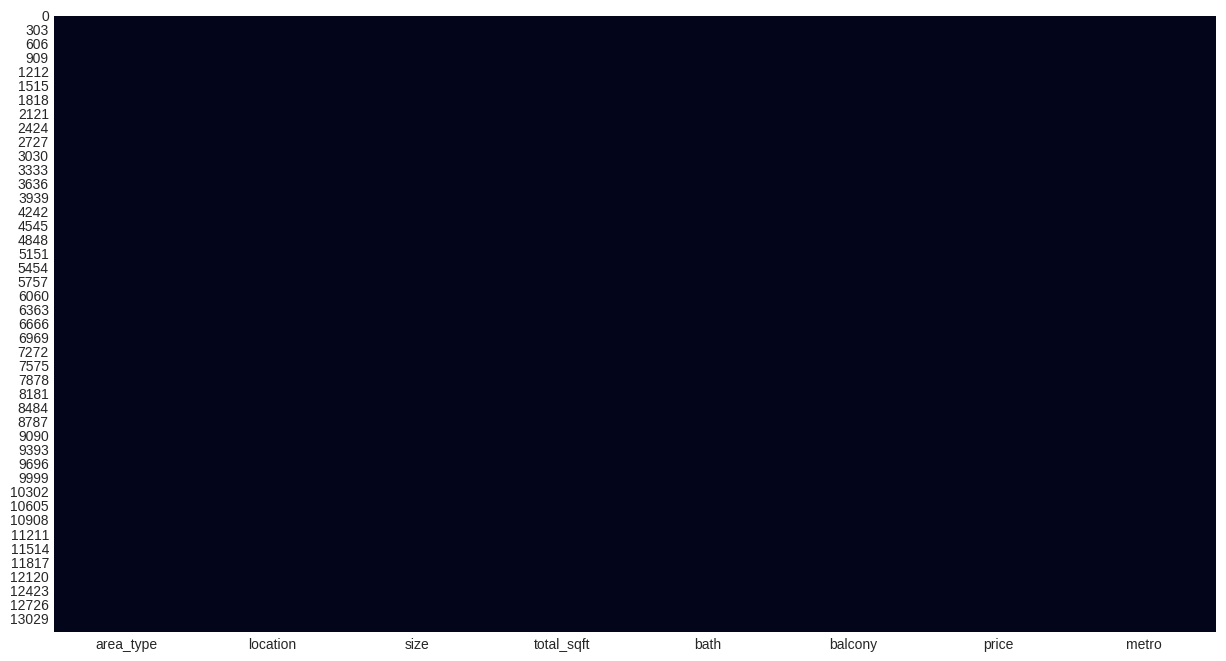

In [ ]:
# visualization for missing value
plt.figure(figsize=(15, 8))

# plot heatmap to check null values

sns.heatmap(dataset.isnull(), cbar=False)

# display the plot
plt.show()

In [ ]:
dataset.isnull().sum()
dataset["metro"].unique()

<IPython.core.display.Javascript object>

array([0., 1.])

In [ ]:
#Now find all the categorical features
categorical_features = [feature for feature in dataset.columns if dataset[feature].dtype == 'O']
categorical_features

<IPython.core.display.Javascript object>

['area_type', 'location', 'size', 'total_sqft']

In [ ]:
dataset[categorical_features].isnull().sum()

<IPython.core.display.Javascript object>

area_type      0
location       0
size          16
total_sqft     0
dtype: int64

In [ ]:
#Since none of the features have null value more than 50%, we will not drop any feature
#Replace all the missing values of categorical features with mode
for feature in categorical_features:
    dataset[feature] = dataset[feature].fillna(dataset[feature].mode()[0])
    
dataset[categorical_features].isnull().sum()

<IPython.core.display.Javascript object>

area_type     0
location      0
size          0
total_sqft    0
dtype: int64

In [ ]:
#Handle categorical features
#check whether any redundant categories are there or not(like 2 BHK and 2 bedroom are same and we can consider it 
#as one category)
dataset['area_type'].unique()

<IPython.core.display.Javascript object>

array(['Built-up Area', 'Super built-up Area', 'Plot Area', 'Carpet Area'],
      dtype=object)

In [ ]:
dataset['location'].unique()

<IPython.core.display.Javascript object>

array(['Anekal', 'Banaswadi', 'Basavangudi', ..., 'Yeshwanthpur',
       'Yeshwanthpur Industrial Suburb', 'Zuzuvadi'], dtype=object)

In [ ]:
#Here we can see redundant categories like 2BHK and 2 bedroom, 4 BHK and 4 bedroom etc
#So, we can create a new column  which will not have these redundant categories for size
#size categories are 2 BHK, 2 bedroom, 3 BHK etc, so better to keep only 1st number i.e 2, 3 ,4 etc as no. of BHK
def consider_only_bhk_number(x):
    token = x.split(" ")
    try:
        return float(token[0])
    except:
        return None
    

<IPython.core.display.Javascript object>

In [ ]:
df2 = dataset.copy()
#Here in consider_only_bhk_number(x), x will be a single value under this feature, here a single 'size'
df2['size'] = df2['size'].apply(consider_only_bhk_number)
df2.head(10)

<IPython.core.display.Javascript object>

,area_type,location,size,total_sqft,bath,balcony,price,metro
0,Built-up Area,Anekal,1.0,351,1.0,1.0,16.00,0.0
1,Super built-up Area,Banaswadi,1.0,527,1.0,0.0,35.00,1.0
2,Super built-up Area,Basavangudi,1.0,670,1.0,1.0,50.00,1.0
3,Super built-up Area,Bhoganhalli,1.0,296,1.0,0.0,22.89,0.0
4,Super built-up Area,Devarabeesana Halli,2.0,1100,2.0,1.0,70.00,0.0
5,Super built-up Area,Devarabeesana Halli,3.0,1672,3.0,2.0,150.00,0.0
6,Built-up Area,Devarabeesana Halli,3.0,1750,3.0,3.0,149.00,0.0
7,Super built-up Area,Devarabeesana Halli,3.0,1670,3.0,2.0,160.00,0.0
8,Super built-up Area,Devarabeesana Halli,3.0,1750,3.0,2.0,150.00,0.0
9,Super built-up Area,Devarabeesana Halli,2.0,1296,2.0,2.0,70.00,0.0


In [ ]:
df2['total_sqft'].unique()

<IPython.core.display.Javascript object>

array(['351', '527', '670', ..., '666', '2504', '1383'], dtype=object)

In [ ]:
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

<IPython.core.display.Javascript object>

In [ ]:
df2[~df2['total_sqft'].apply(is_float)].head(10)

<IPython.core.display.Javascript object>

,area_type,location,size,total_sqft,bath,balcony,price,metro
32,Super built-up Area,Rachenahalli,1.0,385 - 440,1.0,0.000000,19.800,0.0
96,Built-up Area,1st Phase JP Nagar,1.0,78.03Sq. Meter,1.0,1.000000,63.000,1.0
119,Plot Area,2 Bedroom Furnished Farm House in Kolar Road,2.0,1.25Acres,2.0,2.000000,200.000,0.0
234,Plot Area,5 Bedroom Farm House in Lakshmipura,5.0,24Guntha,6.0,2.000000,550.000,1.0
470,Built-up Area,7th Phase JP Nagar,2.0,120Sq. Yards,2.0,1.000000,51.000,1.0
490,Super built-up Area,8th Phase JP Nagar,2.0,1042 - 1105,2.0,0.000000,54.005,1.0
514,Super built-up Area,8th Phase JP Nagar,3.0,1408 - 1455,3.0,0.000000,72.020,1.0
1017,Super built-up Area,Anwar Layout,1.0,660 - 780,1.0,0.000000,32.390,1.0
1050,Built-up Area,Arekere,9.0,4125Perch,9.0,1.584343,265.000,0.0
1065,Plot Area,Arishinakunte,1.0,38Guntha,1.0,0.000000,170.000,0.0


In [ ]:
df2.loc[32]

<IPython.core.display.Javascript object>

area_type     Super built-up Area
location             Rachenahalli
size                          1.0
total_sqft              385 - 440
bath                          1.0
balcony                       0.0
price                        19.8
metro                         0.0
Name: 32, dtype: object

In [ ]:
# As total_sqft is a categorically variable,checking for unique value or units 
def units(x):
    l1 = re.findall(r'\D+\D+',x)
    try:
        if l1[0]==' - ':
            return 'Sqft'
        else:
            return l1[0]
    except:
        return 'Sqft'

<IPython.core.display.Javascript object>

In [ ]:
df2.total_sqft.apply(lambda x:units(x)).unique()


<IPython.core.display.Javascript object>

array(['Sqft', 'Sq. Meter', 'Acres', 'Guntha', 'Sq. Yards', 'Perch',
       'Cents', 'Grounds'], dtype=object)

In [ ]:

def convert_to_sq_feet(total_sqft):
    match_sq_meter = re.match(r'([\d.]+)\s*sq\.?\s*meter', total_sqft, re.I)
    if match_sq_meter:
        area_sq_meter = float(match_sq_meter.group(1))
        area_sq_feet = area_sq_meter * 10.7639
        return area_sq_feet
    

    match_guntha = re.match(r'([\d.]+)\s*guntha', total_sqft, re.I)
    if match_guntha:
        area_guntha = float(match_guntha.group(1))
        area_sq_feet = area_guntha * 1089
        return area_sq_feet
    


    match_perch = re.match(r'([\d.]+)\s*perch', total_sqft, re.I)
    if match_perch:
        area_perch = float(match_perch.group(1))
        area_sq_feet = area_perch * 272.25
        return area_sq_feet
    

    match_sq_yard = re.match(r'([\d.]+)\s*sq\.?\s*yard', total_sqft, re.I)
    if match_sq_yard:
        area_sq_yard = float(match_sq_yard.group(1))
        area_sq_feet = area_sq_yard * 9
        return area_sq_feet
    


    match_acre = re.match(r'([\d.]+)\s*acre', total_sqft, re.I)
    if match_acre:
        area_acre = float(match_acre.group(1))
        area_sq_feet = area_acre * 43560
        return area_sq_feet
    

    
    match_ground = re.match(r'([\d.]+)\s*grounds?', total_sqft, re.I)
    if match_ground:
        area_ground = float(match_ground.group(1))
        area_sq_feet = area_ground * 2400.35
        return area_sq_feet


    match_cents = re.match(r'([\d.]+)\s*cents?', total_sqft, re.I)
    if match_cents:
        area_cents = float(match_cents.group(1))
        area_sq_feet = area_cents * 435.6
        return area_sq_feet


    tokens = total_sqft.split('-')
    if len(tokens) == 2:
        return (float(tokens[0])+float(tokens[1]))/2
        

    # return the original value if it's already in sq. feet or couldn't be matched
    return total_sqft




<IPython.core.display.Javascript object>

In [ ]:
df3= df2.copy()
df3.total_sqft = df3.total_sqft.apply(convert_to_sq_feet)
df3.head()

<IPython.core.display.Javascript object>

,area_type,location,size,total_sqft,bath,balcony,price,metro
0,Built-up Area,Anekal,1.0,351,1.0,1.0,16.00,0.0
1,Super built-up Area,Banaswadi,1.0,527,1.0,0.0,35.00,1.0
2,Super built-up Area,Basavangudi,1.0,670,1.0,1.0,50.00,1.0
3,Super built-up Area,Bhoganhalli,1.0,296,1.0,0.0,22.89,0.0
4,Super built-up Area,Devarabeesana Halli,2.0,1100,2.0,1.0,70.00,0.0


In [ ]:
df3.loc[32]

<IPython.core.display.Javascript object>

area_type     Super built-up Area
location             Rachenahalli
size                          1.0
total_sqft                  412.5
bath                          1.0
balcony                       0.0
price                        19.8
metro                         0.0
Name: 32, dtype: object

In [ ]:
df3[~df3['total_sqft'].apply(is_float)]

<IPython.core.display.Javascript object>

,area_type,location,size,total_sqft,bath,balcony,price,metro


In [ ]:
# Frequency for each loaction
location_freq = pd.Series(df3.location.value_counts()).head(25)
locations = pd.DataFrame(location_freq).reset_index().rename(columns={'index':'location','location':'frequency'})


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

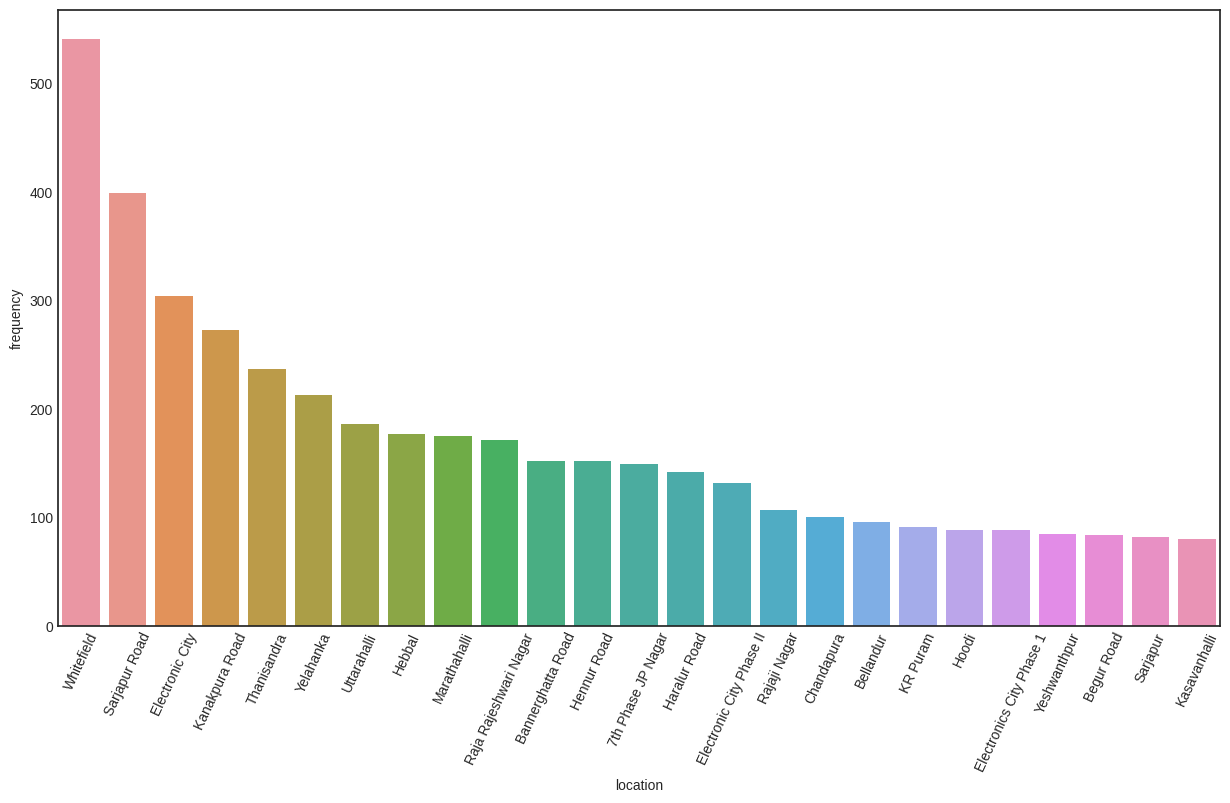

In [ ]:
# barplot

plt.figure(figsize=(15,8))

sns.barplot( x=locations['location'], y =locations['frequency'])

plt.xticks(rotation=65)

plt.show()

In [ ]:
df3.isnull().sum()

<IPython.core.display.Javascript object>

area_type     0
location      0
size          0
total_sqft    0
bath          0
balcony       0
price         0
metro         0
dtype: int64

In [ ]:
df3['total_sqft'] = df3['total_sqft'].astype(float)

<IPython.core.display.Javascript object>

In [ ]:
#Introduce price per sq ft feature, which is a very important feature
#Price is in lakh, so multiply with 1 lakh and then divide price with total_sqft to get price per sqft
df3['price per sqft'] = (df3['price']*100000)/df3['total_sqft']
df3.head()

<IPython.core.display.Javascript object>

,area_type,location,size,total_sqft,bath,balcony,price,metro,price per sqft
0,Built-up Area,Anekal,1.0,351.0,1.0,1.0,16.00,0.0,4558.404558
1,Super built-up Area,Banaswadi,1.0,527.0,1.0,0.0,35.00,1.0,6641.366224
2,Super built-up Area,Basavangudi,1.0,670.0,1.0,1.0,50.00,1.0,7462.686567
3,Super built-up Area,Bhoganhalli,1.0,296.0,1.0,0.0,22.89,0.0,7733.108108
4,Super built-up Area,Devarabeesana Halli,2.0,1100.0,2.0,1.0,70.00,0.0,6363.636364


**Handle rare categorical features**

In [ ]:
df4= df3.copy()
#Check how many unique area_types are there
len(df4['area_type'].unique())

<IPython.core.display.Javascript object>

4

For area_type, there are 4 unique categories. so if we do one hot encoding(to convert categorical feature into numerical features) , then 4 new columns will be created and the original area_type column will be removed, so 3 extra new columns will be created, which is feasible

In [ ]:
#check how many unique location are there
len(df4['location'].unique())

<IPython.core.display.Javascript object>

1294

There are 1294 unique categories and one hot encoding will create new 1293 features, not at all feasible. This phenomenon of having some many new features getting introduced due to one hot encoding is called dimensionality curse and we need to avoid it. For that we need to perform dimensionality reduction. One technique is to label all rare categorical features with a single label "Other"

In [ ]:
#Remove leading and ending spaces from the location so that no ambiguity is created
df4['location'] = df4['location'].apply(lambda x: x.strip())

<IPython.core.display.Javascript object>

In [ ]:
temp = df4['location'].value_counts()
temp

<IPython.core.display.Javascript object>

Whitefield              541
Sarjapur Road           399
Electronic City         304
Kanakpura Road          273
Thanisandra             237
                       ... 
Kalhalli                  1
Kalkere Channasandra      1
KAMAKIYA                  1
Kamdhenu Nagar            1
Zuzuvadi                  1
Name: location, Length: 1294, dtype: int64

We can see that there are many locations which appear only once, these are rare data. We can replace all these rare locations with a single label named 'other'. We can keep a threshold like if no. of records for a location is less than 10(generally consider 1% of total data), then it is rare and we will mark it as 'other'



In [ ]:
len(temp[temp >= 30])

<IPython.core.display.Javascript object>

100

In [ ]:
location_less_than_30 = temp[temp < 30]
location_less_than_30

<IPython.core.display.Javascript object>

Dodda Nekkundi          29
Kammasandra             29
Kudlu                   29
BTM 2nd Stage           29
Horamavu Banaswadi      28
                        ..
Kalhalli                 1
Kalkere Channasandra     1
KAMAKIYA                 1
Kamdhenu Nagar           1
Zuzuvadi                 1
Name: location, Length: 1194, dtype: int64

In [ ]:
locations_considered = temp[temp >= 30]
locations_considered

<IPython.core.display.Javascript object>

Whitefield            541
Sarjapur Road         399
Electronic City       304
Kanakpura Road        273
Thanisandra           237
                     ... 
Ambedkar Nagar         31
Doddathoguru           30
Chikkalasandra         30
Ananth Nagar           30
Kumaraswami Layout     30
Name: location, Length: 100, dtype: int64

In [ ]:
df4['location'] = df4['location'].apply(lambda x: 'other_loc' if x in location_less_than_30 else x )
df4['location'].value_counts()

<IPython.core.display.Javascript object>

other_loc             5379
Whitefield             541
Sarjapur Road          399
Electronic City        304
Kanakpura Road         273
                      ... 
Mahadevpura             31
Chikkalasandra          30
Ananth Nagar            30
Kumaraswami Layout      30
Doddathoguru            30
Name: location, Length: 101, dtype: int64

In [ ]:
#Outlier Removal

#Start with sq ft. per bedroom. We can have a data like 6 BHK and total sq ft is only 1000,which is not possible and clearly
#an outlier. Outlier means an unusually less data or unusually high data, with reference to the threshold considered

#Considering the threshold for sq ft for 1 bedroom to be 300 sq.ft

df4[df4['total_sqft']/df4['size'] < 300].head()

<IPython.core.display.Javascript object>

,area_type,location,size,total_sqft,bath,balcony,price,metro,price per sqft
3,Super built-up Area,Bhoganhalli,1.0,296.0,1.0,0.0,22.89,0.0,7733.108108
26,Plot Area,other_loc,3.0,600.0,2.0,1.0,110.00,0.0,18333.333333
40,Plot Area,other_loc,11.0,1200.0,6.0,3.0,150.00,0.0,12500.000000
43,Plot Area,other_loc,11.0,1200.0,11.0,0.0,170.00,0.0,14166.666667
46,Super built-up Area,other_loc,14.0,1250.0,15.0,0.0,125.00,0.0,10000.000000


In the above records, we can see unusual data(6 bhk has 1020 total sq.ft, 8 bhk has 600 sq.ft etc.). These are wrong datas and therefore are outliers and can be directly removed

In [ ]:
df4.shape

<IPython.core.display.Javascript object>

(13319, 9)

In [ ]:
df5 = df4[~(df4['total_sqft']/df4['size'] < 300)]
df5.shape

<IPython.core.display.Javascript object>

(12571, 9)

In [ ]:
#Now consider price per sq. ft. Price per sq. ft can be too low or too high. 1st we need to check the description of 
#this feature price per sq ft
df5['price per sqft'].describe()

<IPython.core.display.Javascript object>

count     12571.000000
mean       6294.519370
std        4163.403258
min           2.257423
25%        4203.005984
50%        5291.005291
75%        6916.666667
max      176470.588235
Name: price per sqft, dtype: float64

<IPython.core.display.Javascript object>

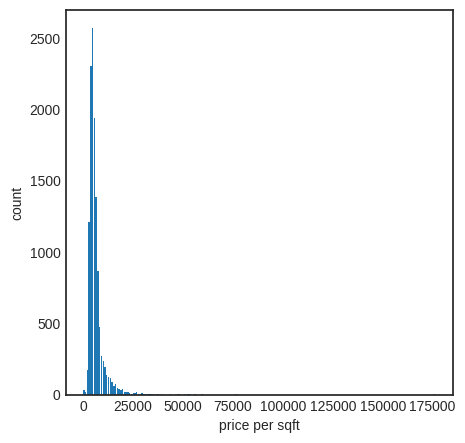

In [ ]:
plt.hist(df5['price per sqft'], bins = 200, rwidth = 0.8)
plt.xlabel('price per sqft')
plt.ylabel('count')
plt.show()

From the histogram, we can see that the price per sqft column follows somewhat normal distribution. In case of any normal distribution, most of the values are centred around the mean i.e close to the mean. From the describe(), we can see that mean is 6312 and this value lies b/w 50-75 percentile. 25 percentile is 4209 meaning 25% of total no. of records have price per sqft value less than 4209 50 % of total no. of records have price per sqft value less than 5294 and 75% of total no. of records have price per sqft value less than 6927. So, we can say that from 25% to 75% i.e 50% of data are close to mean i.e 6312 and thus it roughly follows normal distribution

Since it follows normal distribution, we can apply standard deviation method to remove the outliers

In [ ]:
#Generally we consider 3 standard deviation while removing outliers.
#It means mean is at centre, lower limit = mean - 3* 1 standard deviation, upper limit =  mean + 3* 1 standard deviation
#If the value lies b/w this lower limit and upper limit, it is not a outlier., else it is a outlier
#However here we are seeing that lower limit will be negative if we consider 3 standard deviation and price per sqft has min
#value as 267, so none of the values are negative, so all the values lower than mean will be considered as non-outlier, 
#which is incorrect. So, in this case we have to consider 1 standard deviation

#Whenever we are calculating mean and std, we should always do groupby first and then calculate as mean is for the all the 
#records under groupby category (here location)
def remove_pps_outliers(df):
    final_df = pd.DataFrame()
    for key, subdf in df.groupby('location'):
         upper_limit = subdf['price per sqft'].mean() + 1*subdf['price per sqft'].std()
         lower_limit = subdf['price per sqft'].mean() - 1*subdf['price per sqft'].std()
         subdf_without_outliers = subdf[(subdf['price per sqft'] >= lower_limit) & (subdf['price per sqft'] <= upper_limit)]
         final_df = pd.concat([final_df , subdf_without_outliers], ignore_index = True)
    return final_df

df6 = remove_pps_outliers(df5)
df6.shape


<IPython.core.display.Javascript object>

(10635, 9)

In [ ]:
#No. of outlier records removed
df5.shape[0] - df6.shape[0]

<IPython.core.display.Javascript object>

1936

In [ ]:
#Bathrooms: Its unusual that a 2 BHK house has 5 or 6 bathrooms, so those are outliers
#For bathroom , if no. of bathrooms greater than no. of bed rooms + 2, then it is an outlier and remove them
df6 = df6[df6['bath'] < df6['size'] + 2]
df6.shape

<IPython.core.display.Javascript object>

(10539, 9)

In [ ]:
#Balcony : Its unusual that a 2 BHK house has 5 or 6 balcony, so those are outliers
#For balcony, if no. of balcony is greater than no of bed rooms + 2, then it is an outlier and remove them
df6 = df6[df6['balcony'] < df6['size'] + 2]
df6.shape

<IPython.core.display.Javascript object>

(10539, 9)

<IPython.core.display.Javascript object>

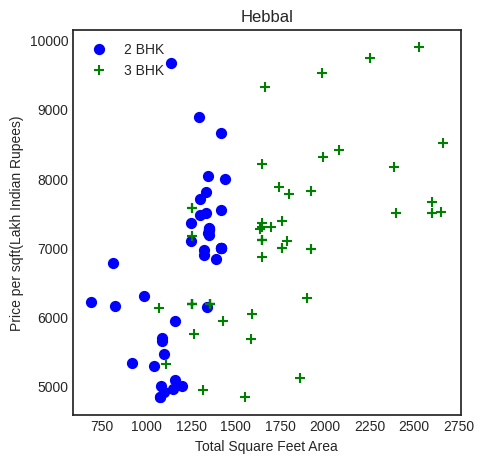

In [ ]:
def plot_scatter_chart(df,location):
    bhk2 = df[(df['location']==location) & (df['size']==2)]
    bhk3 = df[(df['location']==location) & (df['size']==3)]
    plt.scatter(bhk2['total_sqft'],bhk2['price per sqft'],color='blue',label='2 BHK', s=50)
    plt.scatter(bhk3['total_sqft'],bhk3['price per sqft'],marker='+', color='green',label='3 BHK', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price per sqft(Lakh Indian Rupees)")
    plt.title(location)
    plt.legend()
    
plot_scatter_chart(df6,"Hebbal")

In [ ]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_dict = {}
        for bhk, bhk_df in location_df.groupby('size'):
            bhk_dict[bhk] = bhk_df['price per sqft'].mean()
             
        for bhk, bhk_df in location_df.groupby('size'):
            prev_bhk_mean = bhk_dict.get(bhk-1)
            if prev_bhk_mean:
                q1 = bhk_df['price per sqft'].quantile(0.25)
                q3 = bhk_df['price per sqft'].quantile(0.75)
                iqr = q3 - q1
                lower_bound = q1 - (1.5 * iqr)
                upper_bound = q3 + (1.5 * iqr)
                bhk_df = bhk_df[(bhk_df['price per sqft'] >= lower_bound) & (bhk_df['price per sqft'] <= upper_bound)]
                bhk_df['price per sqft'] = np.log(bhk_df['price per sqft'])
                df.loc[bhk_df.index] = bhk_df

    return df.drop(exclude_indices,axis='index')

df7 = remove_bhk_outliers(df6)
df7.shape

<IPython.core.display.Javascript object>

<ipython-input-59-f23b9f12804b>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bhk_df['price per sqft'] = np.log(bhk_df['price per sqft'])
<ipython-input-59-f23b9f12804b>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bhk_df['price per sqft'] = np.log(bhk_df['price per sqft'])
<ipython-input-59-f23b9f12804b>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

(10539, 9)

In [ ]:
#Now all outliers removed
#Since price per sqft column is only for removing outliers, so we can delete it
df7.drop(['price per sqft'], axis = 'columns', inplace = True)
df7.shape

<IPython.core.display.Javascript object>

(10539, 8)

In [ ]:
#Convert categorical data into numerical data using one hot encoding

#For area type
dum = pd.get_dummies(df7['area_type'])
dum.head()

<IPython.core.display.Javascript object>

,Built-up Area,Carpet Area,Plot Area,Super built-up Area
0,0,0,0,1
1,1,0,0,0
2,1,0,0,0
3,0,0,0,1
4,1,0,0,0


In [ ]:
df8 = pd.concat([df7,dum], axis = 'columns')


<IPython.core.display.Javascript object>

In [ ]:
#Drop area_type as dummy columns have already been created
df8.drop(['area_type'] , axis = 1, inplace = True)
df8.head()

<IPython.core.display.Javascript object>

,location,size,total_sqft,bath,balcony,price,metro,Built-up Area,Carpet Area,Plot Area,Super built-up Area
0,5th Phase JP Nagar,2.0,1075.0,2.0,2.0,60.0,1.0,0,0,0,1
1,5th Phase JP Nagar,2.0,1150.0,3.0,3.0,52.5,1.0,1,0,0,0
2,5th Phase JP Nagar,2.0,1256.0,2.0,1.0,62.8,1.0,1,0,0,0
3,5th Phase JP Nagar,2.0,1207.0,2.0,2.0,63.0,1.0,0,0,0,1
4,5th Phase JP Nagar,3.0,1725.0,2.0,2.0,100.0,1.0,1,0,0,0


In [ ]:
#Do one hot encoding for location
location_dummy = pd.get_dummies(df8['location'])
df9 = pd.concat([df8,location_dummy], axis = 'columns')
df9.drop(['location'], axis = 1, inplace = True)
df9.shape

<IPython.core.display.Javascript object>

(10539, 111)

In [ ]:
location_dummy

<IPython.core.display.Javascript object>

,5th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,Akshaya Nagar,Ambedkar Nagar,Ananth Nagar,Anekal,Attibele,Balagere,...,Uttarahalli,Varthur,Vidyaranyapura,Vijayanagar,Vittasandra,Whitefield,Yelahanka,Yelahanka New Town,Yeshwanthpur,other_loc
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10630,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
10631,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
10632,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
10633,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
#Now the model is ready to be trained
X = df9.drop(['price'],axis='columns')
X.shape

<IPython.core.display.Javascript object>

(10539, 110)

In [ ]:
y = df9['price']

<IPython.core.display.Javascript object>

In [ ]:
y.shape

<IPython.core.display.Javascript object>

(10539,)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=3)

<IPython.core.display.Javascript object>

In [ ]:
print(X.shape,X_train.shape,X_test.shape)

<IPython.core.display.Javascript object>

(10539, 110) (8431, 110) (2108, 110)


In [ ]:
from sklearn.linear_model import LinearRegression
lr_clf = LinearRegression()
lr_clf.fit(X_train,y_train)
lr_clf.score(X_test,y_test)

<IPython.core.display.Javascript object>

0.7730325907774724

In [ ]:
X_train

<IPython.core.display.Javascript object>

,size,total_sqft,bath,balcony,metro,Built-up Area,Carpet Area,Plot Area,Super built-up Area,5th Phase JP Nagar,...,Uttarahalli,Varthur,Vidyaranyapura,Vijayanagar,Vittasandra,Whitefield,Yelahanka,Yelahanka New Town,Yeshwanthpur,other_loc
5204,2.0,1066.0,2.0,2.0,0.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
7849,2.0,1225.0,2.0,2.0,1.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2629,3.0,1689.0,3.0,2.0,1.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4540,3.0,1404.0,2.0,0.0,0.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
8108,2.0,1000.0,2.0,2.0,0.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6456,2.0,985.0,2.0,1.0,0.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
9242,3.0,1390.0,3.0,2.0,0.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9950,4.0,3000.0,5.0,2.0,1.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1690,3.0,1450.0,3.0,2.0,0.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

<IPython.core.display.Javascript object>

In [ ]:
# Decision tree
dt_clf = DecisionTreeRegressor()
dt_clf.fit(X_train, y_train)
dt_clf.score(X_test, y_test)

<IPython.core.display.Javascript object>

0.5681579843261051

In [ ]:
# Random forest
rf_clf = RandomForestRegressor()
rf_clf.fit(X_train, y_train)
rf_clf.score(X_test, y_test)

<IPython.core.display.Javascript object>

0.7025996521826351

In [ ]:
from xgboost import XGBRegressor
xgb_reg = XGBRegressor()
xgb_reg.fit(X_train, y_train)
xgb_reg.score(X_test, y_test)

<IPython.core.display.Javascript object>

0.7259438420138473

### **K-fold cross validation**

In [ ]:
#Use K-fold cross validation  for Linear Regression
#Shuffle split will randomize the dataset so that each of the fold will have equal distribution
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv=ShuffleSplit(n_splits=5, test_size=0.2, random_state=3)
cross_val_score(lr_clf,X,y,cv=cv)


<IPython.core.display.Javascript object>

array([0.77303259, 0.64942885, 0.86446469, 0.76801649, 0.79234473])

In [ ]:
import statistics
round(statistics.mean(cross_val_score(lr_clf,X,y,cv=cv))*100,2)

<IPython.core.display.Javascript object>

76.95

In [ ]:
lr_clf

<IPython.core.display.Javascript object>

LinearRegression()

In [ ]:
#Use K-fold cross validation  for DecisionTreeRegressor

cv=ShuffleSplit(n_splits=5, test_size=0.2, random_state=3)
cross_val_score(dt_clf,X,y,cv=cv)

<IPython.core.display.Javascript object>

array([0.59258446, 0.41082749, 0.44450157, 0.67042648, 0.48825301])

In [ ]:
round(statistics.mean(cross_val_score(dt_clf,X,y,cv=cv))*100,2)

<IPython.core.display.Javascript object>

54.44

In [ ]:
#Use K-fold cross validation  for RandomForestRegressor

cv=ShuffleSplit(n_splits=5, test_size=0.2, random_state=3)
cross_val_score(rf_clf,X,y,cv=cv)

<IPython.core.display.Javascript object>

array([0.70031417, 0.64025281, 0.73583823, 0.77283225, 0.77904201])

In [ ]:
round(statistics.mean(cross_val_score(rf_clf,X,y,cv=cv))*100,2)

<IPython.core.display.Javascript object>

72.72

### **Hyperparameter Tuning - GridSearchCV**

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
def find_best_model_using_gridsearchcv(X, y):
    algos = {
        'linear_regression': {
            'model': LinearRegression(),
            'params': {
                'fit_intercept': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1, 2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion': ['mse', 'friedman_mse'],
                'splitter': ['best', 'random']
            }
        },
        'random_forest': {
            'model': RandomForestRegressor(),
            'params': {
                'n_estimators': [100, 200, 500],
                'max_depth': [3, 5, 10]
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs = GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X, y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])


find_best_model_using_gridsearchcv(X,y)

<IPython.core.display.Javascript object>

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py", line 1247, in fit
    super().fit(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py", line 177, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _valida

KeyboardInterrupt: ignored

In [ ]:
X.head()

<IPython.core.display.Javascript object>

,size,total_sqft,bath,balcony,metro,Built-up Area,Carpet Area,Plot Area,Super built-up Area,5th Phase JP Nagar,...,Uttarahalli,Varthur,Vidyaranyapura,Vijayanagar,Vittasandra,Whitefield,Yelahanka,Yelahanka New Town,Yeshwanthpur,other_loc
0,2.0,1075.0,2.0,2.0,1.0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2.0,1150.0,3.0,3.0,1.0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,2.0,1256.0,2.0,1.0,1.0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,2.0,1207.0,2.0,2.0,1.0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,3.0,1725.0,2.0,2.0,1.0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
X.columns

<IPython.core.display.Javascript object>

Index(['size', 'total_sqft', 'bath', 'balcony', 'metro', 'Built-up Area',
       'Carpet Area', 'Plot Area', 'Super built-up Area', '5th Phase JP Nagar',
       ...
       'Uttarahalli', 'Varthur', 'Vidyaranyapura', 'Vijayanagar',
       'Vittasandra', 'Whitefield', 'Yelahanka', 'Yelahanka New Town',
       'Yeshwanthpur', 'other_loc'],
      dtype='object', length=110)

In [ ]:
# X.columns = X.columns.str.strip()
# X.columns

<IPython.core.display.Javascript object>

In [ ]:
np.where(X.columns == 'Plot Area')[0][0]

<IPython.core.display.Javascript object>

7

In [ ]:
def predict_val(area_type , location, size, total_sqft, bath, balcony):
    area_type_ind = np.where(X.columns == area_type)[0][0]
    
    if location not in locations_considered:
        location = 'other_loc'
    location_ind = np.where(X.columns == location)[0][0]
    
    data = np.zeros(len(X.columns))
    data[0] = size
    data[1] = total_sqft
    data[2] = bath
    data[3] = balcony
    data[area_type_ind] = 1
    data[location_ind] = 1
    
    return lr_clf.predict([data])[0]

<IPython.core.display.Javascript object>

In [ ]:
predict_val('Built-up Area','Anekal',2,1000,3,2)

<IPython.core.display.Javascript object>

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


37.609671763782

In [ ]:
predict_val('Built-up Area','Indira Nagar',2,1000,2,2)

<IPython.core.display.Javascript object>

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


169.1518669725915

In [ ]:
predict_val('Plot Area','Indira Nagar',3,2000,2,2)

<IPython.core.display.Javascript object>

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


243.017485930389

In [ ]:
predict_val('Carpet Area','Indira Nagar',3,2000,2,2)


<IPython.core.display.Javascript object>

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


231.464213974127